<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/main/assignment_2/Assignment_2_2AMM10_22_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Details

## Group Name: group21

### Student 1: N.P.G.T. van Beuningen	1353624

### Student 2: D.P.M. van der Hoorn	1873334

### Student 3: L.R. Siecker	1344838

# Loading Data and Preliminaries

In [1]:
from google.colab import drive
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import requests
import pickle
import sklearn.metrics as sm
import time
from tqdm.notebook import tqdm, trange

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.cuda.memory import list_gpu_processes
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
base_url = "https://github.com/lsiecker/Deep-Learning/raw/main/assignment_2/data/"

In [3]:
def load_data(url, task):
    """
    Loads a numpy array from surfdrive.

    Input:
    url: Download link of dataset

    Outputs:
    dataset: numpy array with input features or labels
    """

    response = requests.get(url)
    response.raise_for_status()

    array = load_array(io.BytesIO(response.content), task)

    return array

In [4]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [5]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_data(f"{base_url}task%201/train/trajectory_0.npz?raw=true", task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [6]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_data(f'{base_url}task%202_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_data(f'{base_url}task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Helper Functions Setup

In [7]:
drive.mount('/content/drive')
destination_file = '/content/drive/MyDrive/'

def save_dataset(dataset, filename):
  "Saves dataset into file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'wb') as file:
     pickle.dump(dataset, file)
  print(f"Dataset saved to {filename}.")

def load_dataset(filename):
  "Loades dataset from file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'rb') as file:
      dataset = pickle.load(file)
  return dataset

Mounted at /content/drive


In [8]:
class PlotTraining():
    def __init__(self):
      self.train_loss = []
      self.evaluation_loss = []
      self.test_loss = []

    def add_train(self, loss):
      self.train_loss.append(loss)

    def add_evaluation(self, loss):
      self.evaluation_loss.append(loss)

    def add_test(self, loss):
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax2 = ax1.twinx()
      if self.train_loss is not [None] * len(self.train_loss) \
          or self.evaluation_loss is not [None] * len(self.evaluation_loss) \
          or self.test_loss is not [None] * len(self.test_loss):
        ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()

In [9]:
def sequence_rotation(source_sequence):
    x = source_sequence[:, 1]
    y = source_sequence[:, 2]
    v_x = source_sequence[:, 3]
    v_y = source_sequence[:, 4]

    # Create four rotated copies of the batch of sequences
    rotated_sequences = [
        torch.stack([source_sequence[:, 0], x, y, v_x, v_y], dim=1),  # 0 degrees rotation
        torch.stack([source_sequence[:, 0], y, -x, -v_y, v_x], dim=1),  # 90 degrees rotation
        torch.stack([source_sequence[:, 0], -x, -y, -v_x, -v_y], dim=1),  # 180 degrees rotation
        torch.stack([source_sequence[:, 0], -y, x, v_y, -v_x], dim=1),  # 270 degrees rotation
    ]

    rotated_sequences_tensor = torch.stack(rotated_sequences, dim=1)  # Shape: [batch_size, 4, sequence_length, 5]

    return rotated_sequences_tensor.view(rotated_sequences_tensor.shape[0] * rotated_sequences_tensor.shape[1], 5)

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # arrays are stored as tuples; get respective lists
    source_points = [x[0] for x in batch]
    target_points = [x[1] for x in batch]

    source_sequences = [sequence_rotation(sequence) for sequence in source_points]

    # pad sequences in batch
    source_padded = pad_sequence(sequences = source_sequences,
                             batch_first = True)
    target_padded = pad_sequence(sequences = target_points,
                             batch_first = True)

    return source_padded.to(device), target_padded.to(device)

In [10]:
def train(dataloader, log_interval, task23):

  model.train()

  start_time = time.time()
  for idx, (trajectory_points, target_points) in enumerate(tqdm(dataloader)):
        trajectory_points = trajectory_points.to(device)
        target_points = target_points.to(device).narrow(dim=-1, start=0, length=2)

        model.optimizer.zero_grad()
        y_pred = model(trajectory_points)

        if task23:
          reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
          loss = model.criterion(reshaped_y_pred, target_points)
        else:
          loss = model.criterion(y_pred, target_points)

        loss.backward()
        model.optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              loss))
            start_time = time.time()

  return loss

def evaluate(dataloader, task23):
    model.eval()

    with torch.no_grad():
        for idx, (trajectory_points, target_points) in enumerate(tqdm(dataloader)):

            trajectory_points = trajectory_points.to(device)
            target_points = target_points.to(device).narrow(dim=-1, start=0, length=2)

            y_pred = model(trajectory_points)
            if task23:
              reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
              loss = model.criterion(reshaped_y_pred, target_points)
            else:
              loss = model.criterion(y_pred, target_points)

    return loss

# Model Setup

In [11]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector
        """

        output, _ = self.rnn(src)

        output = self.dropout(output)

        return output

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_size, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(hid_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_size)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, input):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sequence that is
        used for position prediction
        """

        output, _ = self.rnn(input)

        prediction = self.fc_out(output)

        # Only select points that were in original dataset
        reduced_output = prediction[:, ::4, :]

        return reduced_output

In [13]:
class TrainPointPredictor(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.criterion = nn.MSELoss()

        self.double()


    def forward(self, source_points):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.

        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]

        Outputs:
        output:
        """

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        input = self.encoder(source_points)
        output = self.decoder(input)

        return output

# Task **1**

## Data Handling and Preprocessing

In [14]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%201/train/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(train_data, "train_data")

In [15]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%201/test/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(test_data, "test_data")

In [16]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  1.72s | train loss   17.574 validation loss   16.746 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  0.64s | train loss   14.460 validation loss   12.374 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  0.65s | train loss    8.762 validation loss    7.771 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  0.67s | train loss    5.916 validation loss    6.700 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  0.65s | train loss    6.229 validation loss    6.312 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  0.76s | train loss    5.935 validation loss    5.910 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  0.79s | train loss    6.034 validation loss    5.799 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  0.82s | train loss    5.869 validation loss    5.668 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  0.82s | train loss    5.112 validation loss    5.531 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  0.85s | train loss    5.408 validation loss    5.421 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  0.73s | train loss    5.325 validation loss    5.394 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  0.65s | train loss    5.412 validation loss    5.378 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  0.65s | train loss    5.313 validation loss    5.303 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  0.66s | train loss    5.502 validation loss    5.260 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  0.67s | train loss    5.146 validation loss    5.215 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  0.66s | train loss    5.627 validation loss    5.191 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  0.67s | train loss    5.447 validation loss    5.152 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  0.76s | train loss    4.770 validation loss    5.123 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  0.66s | train loss    5.299 validation loss    5.120 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  0.67s | train loss    5.393 validation loss    5.025 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  0.66s | train loss    5.198 validation loss    5.086 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  0.68s | train loss    4.911 validation loss    5.048 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  0.66s | train loss    5.093 validation loss    5.063 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  0.67s | train loss    5.402 validation loss    5.013 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  0.67s | train loss    4.736 validation loss    4.931 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  0.79s | train loss    4.882 validation loss    4.994 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  0.83s | train loss    5.119 validation loss    4.960 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  0.86s | train loss    4.704 validation loss    4.955 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  0.87s | train loss    5.067 validation loss    4.917 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  0.81s | train loss    5.403 validation loss    4.964 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  0.75s | train loss    5.190 validation loss    4.957 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  0.66s | train loss    4.823 validation loss    4.964 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  1.08s | train loss    5.199 validation loss    4.943 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  1.06s | train loss    5.104 validation loss    4.876 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  1.04s | train loss    5.155 validation loss    4.894 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  0.67s | train loss    4.853 validation loss    4.886 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  0.68s | train loss    5.172 validation loss    4.903 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  0.67s | train loss    4.441 validation loss    4.849 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  0.69s | train loss    4.701 validation loss    4.860 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  0.68s | train loss    5.023 validation loss    4.908 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  0.67s | train loss    4.464 validation loss    4.846 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  0.67s | train loss    4.907 validation loss    4.843 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  0.69s | train loss    4.458 validation loss    4.898 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  0.72s | train loss    4.553 validation loss    4.832 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  0.87s | train loss    5.119 validation loss    4.848 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  0.81s | train loss    4.955 validation loss    4.796 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  0.78s | train loss    4.622 validation loss    4.780 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  0.83s | train loss    4.928 validation loss    4.795 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  1.03s | train loss    5.138 validation loss    4.852 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  0.85s | train loss    4.803 validation loss    4.845 
-----------------------------------------------------------


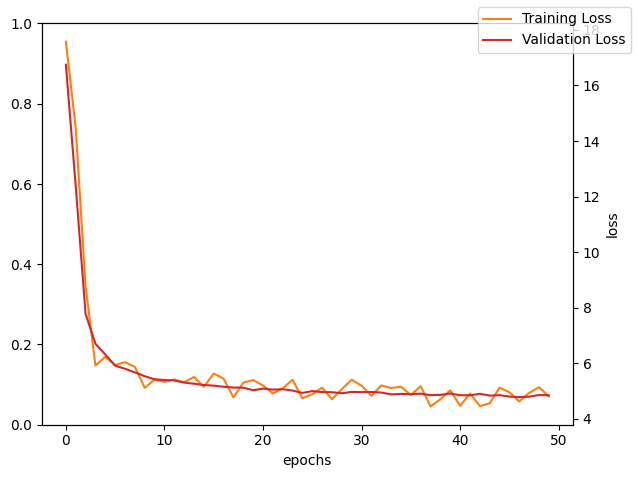

In [17]:
OUTPUT_SIZE = 2 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50
DROPOUT = 0.2 #  BEST: 0.0
N_LAYERS = 1 # Number of RNN layers  BEST: 2
HIDDEN_DIM = 64 # Dimension of the lstm's hidden state (Embedding)  BEST: 64
LEARNING_RATE = 1e-2 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_losses, val_losses = [], []

plotter = PlotTraining()
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = False).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = False).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [18]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0)

In [19]:
y_pred = model(test_x_pad.to(device)).reshape(900, 2).cpu().detach().numpy()
y_test = test_y_pad.reshape(900, 2).cpu()
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

Mean absolute error = 1.23
Mean squared error = 3.38
Median absolute error = 0.77
Explain variance score = 0.77
R2 score = 0.77


# Task **2**

## Data Handling and Preprocessing

In [46]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data_task23")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%202_3/train/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(train_data, "train_data_task23")

In [47]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data_task23")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%202_3/test/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(test_data, "test_data_task23")

In [45]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_batch)

## Model Training

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   1 |   500/  800 batches | loss    3.164


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  5.28s | train loss    2.622 validation loss    2.884 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   2 |   500/  800 batches | loss    2.656


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  5.15s | train loss    2.905 validation loss    2.922 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   3 |   500/  800 batches | loss    2.982


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  5.16s | train loss    3.033 validation loss    3.121 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   4 |   500/  800 batches | loss    2.310


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  5.12s | train loss    2.973 validation loss    2.836 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   5 |   500/  800 batches | loss    2.594


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  5.27s | train loss    3.052 validation loss    3.001 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   6 |   500/  800 batches | loss    2.006


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  5.15s | train loss    2.949 validation loss    2.801 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   7 |   500/  800 batches | loss    1.950


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  5.12s | train loss    2.522 validation loss    2.681 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   8 |   500/  800 batches | loss    2.595


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  5.27s | train loss    2.831 validation loss    2.583 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch   9 |   500/  800 batches | loss    1.673


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  5.12s | train loss    3.127 validation loss    2.405 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  10 |   500/  800 batches | loss    1.920


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  5.97s | train loss    2.398 validation loss    2.467 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  11 |   500/  800 batches | loss    1.698


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  5.59s | train loss    2.870 validation loss    2.428 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  12 |   500/  800 batches | loss    1.433


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  5.09s | train loss    2.905 validation loss    2.303 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  13 |   500/  800 batches | loss    1.398


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  5.26s | train loss    2.188 validation loss    2.344 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  14 |   500/  800 batches | loss    1.780


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  5.13s | train loss    2.606 validation loss    2.343 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  15 |   500/  800 batches | loss    1.429


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  5.13s | train loss    2.307 validation loss    2.361 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  16 |   500/  800 batches | loss    1.837


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  5.23s | train loss    2.188 validation loss    2.387 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  17 |   500/  800 batches | loss    1.650


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  5.11s | train loss    2.785 validation loss    2.257 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  18 |   500/  800 batches | loss    1.528


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  5.26s | train loss    2.631 validation loss    2.285 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  19 |   500/  800 batches | loss    1.525


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  5.51s | train loss    2.466 validation loss    2.304 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  20 |   500/  800 batches | loss    1.368


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  5.15s | train loss    2.337 validation loss    2.380 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  21 |   500/  800 batches | loss    1.331


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  5.31s | train loss    2.620 validation loss    2.292 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  22 |   500/  800 batches | loss    1.529


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  5.14s | train loss    2.580 validation loss    2.204 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  23 |   500/  800 batches | loss    1.495


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  5.26s | train loss    2.433 validation loss    2.268 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  24 |   500/  800 batches | loss    1.733


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  5.17s | train loss    2.174 validation loss    2.234 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  25 |   500/  800 batches | loss    1.719


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  5.18s | train loss    2.081 validation loss    2.249 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  26 |   500/  800 batches | loss    1.540


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  5.25s | train loss    2.125 validation loss    2.189 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  27 |   500/  800 batches | loss    1.354


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  5.18s | train loss    2.590 validation loss    2.208 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  28 |   500/  800 batches | loss    1.549


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  5.20s | train loss    2.338 validation loss    2.235 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  29 |   500/  800 batches | loss    1.490


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  5.28s | train loss    2.378 validation loss    2.335 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  30 |   500/  800 batches | loss    1.432


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  5.19s | train loss    2.484 validation loss    2.138 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  31 |   500/  800 batches | loss    1.500


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  6.86s | train loss    2.581 validation loss    2.272 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  32 |   500/  800 batches | loss    1.303


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  7.48s | train loss    2.749 validation loss    2.333 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  33 |   500/  800 batches | loss    0.936


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  5.23s | train loss    2.502 validation loss    2.189 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  34 |   500/  800 batches | loss    1.706


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  5.21s | train loss    2.303 validation loss    2.151 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  35 |   500/  800 batches | loss    1.602


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  5.15s | train loss    2.554 validation loss    2.194 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  36 |   500/  800 batches | loss    1.457


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  5.31s | train loss    2.162 validation loss    2.217 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  37 |   500/  800 batches | loss    1.229


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  5.16s | train loss    2.770 validation loss    2.248 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  38 |   500/  800 batches | loss    1.400


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  5.19s | train loss    2.724 validation loss    2.184 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  39 |   500/  800 batches | loss    1.380


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  5.29s | train loss    2.562 validation loss    2.246 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  40 |   500/  800 batches | loss    1.228


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  5.17s | train loss    2.191 validation loss    2.229 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  41 |   500/  800 batches | loss    1.451


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  5.34s | train loss    2.754 validation loss    2.231 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  42 |   500/  800 batches | loss    1.399


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  5.22s | train loss    2.449 validation loss    2.136 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  43 |   500/  800 batches | loss    1.683


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  5.15s | train loss    2.346 validation loss    2.236 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  44 |   500/  800 batches | loss    1.411


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  5.33s | train loss    2.667 validation loss    2.276 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  45 |   500/  800 batches | loss    2.015


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  5.18s | train loss    2.565 validation loss    2.196 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  46 |   500/  800 batches | loss    1.481


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  5.20s | train loss    2.550 validation loss    2.152 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  47 |   500/  800 batches | loss    1.619


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  5.29s | train loss    2.706 validation loss    2.164 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  48 |   500/  800 batches | loss    1.462


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  5.17s | train loss    2.287 validation loss    2.164 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  49 |   500/  800 batches | loss    1.397


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  5.29s | train loss    2.989 validation loss    2.185 
-----------------------------------------------------------


  0%|          | 0/800 [00:00<?, ?it/s]

| epoch  50 |   500/  800 batches | loss    1.203


  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  5.30s | train loss    3.121 validation loss    2.160 
-----------------------------------------------------------


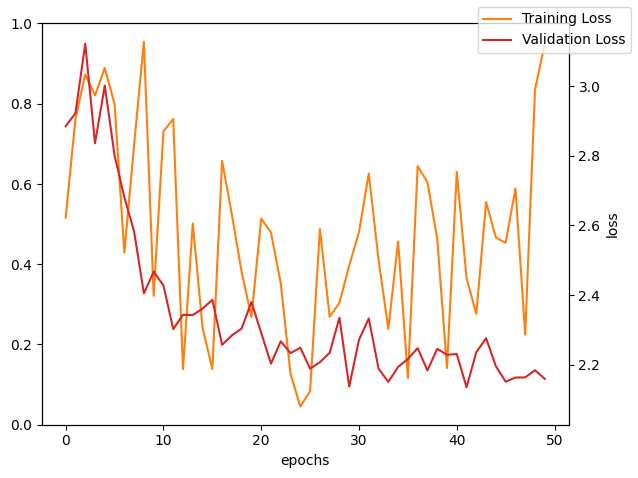

In [48]:
OUTPUT_SIZE = 49*4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50, starts overfitting afterwards
DROPOUT = 0.5 #  BEST: 0.5
N_LAYERS = 1 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 512 # Dimension of the lstm's hidden state (Embedding)  BEST: 256
LEARNING_RATE = 0.05 #  BEST: 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_loss, val_loss = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = True).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = True).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [49]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

In [50]:
y_pred = model(test_x_pad.to(device))
reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2).reshape(900, 98).cpu().detach().numpy()
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2).reshape(900, 98)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, reshaped_y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, reshaped_y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, reshaped_y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, reshaped_y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, reshaped_y_pred), 2))

Mean absolute error = 2.53
Mean squared error = 10.53
Median absolute error = 2.1
Explain variance score = 0.34
R2 score = 0.34


In [26]:
y_pred.shape, y_test.shape

(torch.Size([100, 9, 196]), torch.Size([900, 98]))

torch.Size([100, 9, 196]) torch.Size([100, 9, 49, 2])
(100, 9, 49, 2)
(100, 9, 49, 2)


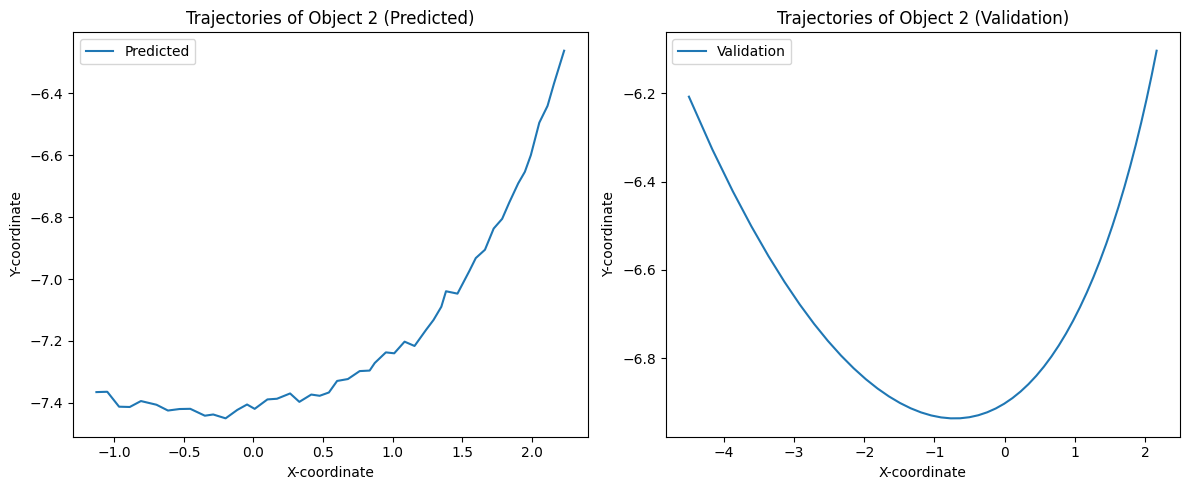

In [57]:
import numpy as np
import matplotlib.pyplot as plt


print(y_pred.shape, test_y_pad.shape)

# Assuming you have the train and test datasets loaded as numpy arrays
# predicted = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
# predicted = torch.transpose(predicted, 0, 2).permute(0, 2, 1, 3).cpu().detach().numpy()
# validation = test_y_pad.view(test_y_pad.shape[2], test_y_pad.shape[0], test_y_pad.shape[1], test_y_pad.shape[3]).cpu().detach().numpy()

predicted = y_pred.view(100, 9, 49, 4).narrow(dim=-1, start=0, length=2).cpu().detach().numpy()
validation = test_y_pad.cpu().detach().numpy()

print(predicted.shape)
print(validation.shape)

# Specify the object index you want to plot
object_index = 2
batch_index = 0

# Extract the x and y coordinates for the specified object from both datasets
predicted_x = predicted[batch_index, object_index, :, 0]
predicted_y = predicted[batch_index, object_index, :, 1]
validation_x = validation[batch_index, object_index, :, 0]
validation_y = validation[batch_index, object_index, :, 1]

# Filter the values where both x and y are zero
mask = np.logical_or(predicted_x != 0, predicted_y != 0)
predicted_x = predicted_x[mask]
predicted_y = predicted_y[mask]

mask = np.logical_or(validation_x != 0, validation_y != 0)
validation_x = validation_x[mask]
validation_y = validation_y[mask]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the x and y trajectories for the train dataset
axs[0].plot(predicted_x.flatten(), predicted_y.flatten(), label='Predicted')
axs[0].set_xlabel('X-coordinate')
axs[0].set_ylabel('Y-coordinate')
axs[0].set_title(f'Trajectories of Object {object_index} (Predicted)')
axs[0].legend()

# Plot the x and y trajectories for the test dataset
axs[1].plot(validation_x.flatten(), validation_y.flatten(), label='Validation')
axs[1].set_xlabel('X-coordinate')
axs[1].set_ylabel('Y-coordinate')
axs[1].set_title(f'Trajectories of Object {object_index} (Validation)')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Task **3**

## Data Handling and Preprocessing

In [ ]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

In [ ]:
for module in model.modules():
    if module.__class__.__name__.startswith('Dropout'):
        module.train()

fwd_passes = 20
predictions = []

for fwd_pass in range(fwd_passes):
    output = model(test_x_pad.to(device)).view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2).reshape(900, 98)

    np_output = output.detach().cpu().numpy()

    predictions.append(np_output)

predictions = np.array(predictions, dtype=np.float64)

In [ ]:
import scipy.stats

def uncertainty_distribution(predictions):
    mean_predictions = np.mean(predictions, axis=0)

    # Calculate the variance across the runs
    variance = np.var(predictions, axis=0)

    # Calculate the standard deviation across the runs
    std_deviation = np.std(predictions, axis=0)

    # Sample prediction from distribution
    uncertainty_distribution = np.random.normal(loc=mean_predictions, scale=np.sqrt(variance))

    # Calculate the 95% confidence intervals
    CI_lower = mean_predictions - 1.96 * std_deviation
    CI_upper = mean_predictions + 1.96 * std_deviation

    # Stack values so that all information regarding the distribution is available in output
    distribution_array = np.stack((uncertainty_distribution, mean_predictions, variance, std_deviation, CI_lower, CI_upper), axis=-1)
    reshaped_dist_array = np.reshape(distribution_array, (900, 49, 2, 6))

    return uncertainty_distribution, reshaped_dist_array

In [ ]:
sampled_predictions, distribution_predicitons = uncertainty_distribution(predictions)

In [ ]:
# Use sampled predictions to test results
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2).reshape(900, 98)
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, sampled_predictions), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, sampled_predictions), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, sampled_predictions), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, sampled_predictions), 2))
print("R2 score =", round(sm.r2_score(y_test, sampled_predictions), 2))

In [ ]:
# Display example trajectory for first object in distribution_prediction. Order of values: [prediction, mean, variance, standard deviation, lower CI, upper, CI]
print(distribution_predicitons[0])